In [ ]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [1]:
import copy
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from google.colab import files
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from torchvision.models import resnet18
from torchsummary import summary

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
resnet = resnet18(pretrained=True)
resnet.fc = nn.Identity()

for params in resnet.parameters():
    params.requires_grad = False

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device_count = torch.cuda.device_count()
torch.backends.cudnn.benchmark = True

normal_input_shape = (3, 32, 32)
pre_trained_input_shape = (3, 224, 224)
batch_size = 200
epochs = 10
normal_learning_rate = 0.001
transfer_learning_rate = 0.001
momentum = 0.9

print("Device :", device)
print("GPU Count :", device_count)

Device : cuda
GPU Count : 1


In [5]:
def get_data_loaders(validation_split=0.1, model_type='normal'):
    if model_type == 'pretrained':
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
    else:
        mean = [0.5071, 0.4867, 0.4408]
        std = [0.2675, 0.2565, 0.2761]
    
    transform =  T.Compose(
        [
            T.Resize(size=(224 if model_type == 'pretrained' else 32)),
            T.ToTensor(),
            T.Normalize(mean, std)
        ]
    )

    data_set = {}

    data = CIFAR100(root="./data/train",train=True, download=True, transform=transform)
    data_set['test'] = CIFAR100(root="./data/test", train=False, download=True, transform=transform)

    val_len = int(len(data)*validation_split)

    data_set['validation'], data_set['train'] = torch.utils.data.random_split(data, [val_len, len(data)-val_len])
    
    print()
    print("Train data length", len(data_set['train']))
    print("Valiation data length", len(data_set['validation']))
    print("Test data length", len(data_set['test']))
    print()

    data_loader = dict(
        [
        (k, DataLoader(dataset=v, batch_size=batch_size, shuffle=(k == 'train'), pin_memory=True, num_workers=4*device_count, drop_last=True))
        for k, v in data_set.items() 
        ]
    )
    
    return data_loader

In [6]:
# !rm -rf ./data

normal_data_loader = get_data_loaders(validation_split=0.1, model_type='normal')
transfered_data_loader = get_data_loaders(validation_split=0.1, model_type='pretrained')

Files already downloaded and verified
Files already downloaded and verified

Train data length 45000
Valiation data length 5000
Test data length 10000

Files already downloaded and verified
Files already downloaded and verified

Train data length 45000
Valiation data length 5000
Test data length 10000



In [7]:
class Net(nn.Module):
    def __init__(self, pre_trained=None):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=512),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
        )
        self.pre_trained = nn.Identity() if pre_trained == None else pre_trained
        self.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=100),
        )
        

    def forward(self, x):
        if isinstance(self.pre_trained, nn.Identity):
            x = self.conv_layers(x)
        else:
            x = self.pre_trained(x)
        
        x = self.fc(x)
        return x

In [8]:
net = Net().to(device)
print("Normal Conv Net :")
summary(model=net, input_size=normal_input_shape, batch_size=batch_size, device=device)

Normal Conv Net :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [200, 16, 32, 32]             448
              ReLU-2          [200, 16, 32, 32]               0
       BatchNorm2d-3          [200, 16, 32, 32]              32
         MaxPool2d-4          [200, 16, 16, 16]               0
            Conv2d-5          [200, 32, 16, 16]           4,640
              ReLU-6          [200, 32, 16, 16]               0
       BatchNorm2d-7          [200, 32, 16, 16]              64
         MaxPool2d-8            [200, 32, 8, 8]               0
            Conv2d-9            [200, 64, 8, 8]          18,496
             ReLU-10            [200, 64, 8, 8]               0
      BatchNorm2d-11            [200, 64, 8, 8]             128
        MaxPool2d-12            [200, 64, 4, 4]               0
           Conv2d-13           [200, 128, 4, 4]          73,856
             ReLU-14 

In [9]:
transfer_net = Net(pre_trained=resnet).to(device)
print("ResNet Transfer Net :")
summary(model=transfer_net, input_size=pre_trained_input_shape, batch_size=batch_size, device=device)

ResNet Transfer Net :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [200, 64, 112, 112]           9,408
       BatchNorm2d-2        [200, 64, 112, 112]             128
              ReLU-3        [200, 64, 112, 112]               0
         MaxPool2d-4          [200, 64, 56, 56]               0
            Conv2d-5          [200, 64, 56, 56]          36,864
       BatchNorm2d-6          [200, 64, 56, 56]             128
              ReLU-7          [200, 64, 56, 56]               0
            Conv2d-8          [200, 64, 56, 56]          36,864
       BatchNorm2d-9          [200, 64, 56, 56]             128
             ReLU-10          [200, 64, 56, 56]               0
       BasicBlock-11          [200, 64, 56, 56]               0
           Conv2d-12          [200, 64, 56, 56]          36,864
      BatchNorm2d-13          [200, 64, 56, 56]             128
             ReLU

In [10]:
def model_train(model, criterion, optimizer, data_loader, epochs,
                epochs_to_watch = -1, accuracy_min_diff = 0.001, max_val_acc_needed = None):
    history = {
        'epochs' : 0,
        'train' : {
            'losses' : [],
            'accuracies' : [],
            'total_loss' : 0,
            'total_acc' : 0
        },
        'validation' : {
            'losses' : [],
            'accuracies' : [],
            'total_loss' : 0,
            'total_acc' : 0
        }
    }
    
    best_state_dict = copy.deepcopy(model.state_dict())
    best_val_acc = -float('inf')
    epochs_no_improve = 0
    width = len(str(epochs))

    train_start = time.time()
    # =============================================

    for e in range(1, epochs+1):
        try:
            epoch_start = time.time()
            total_loss = 0
            total_acc = 0
            
            print(f"Epoch[{e:0{width}}/{epochs}] :: ", end="")
            # ===============================================
            for phase in ['train', 'validation']:

                loader = data_loader[phase]

                model.train(phase == 'train')
                with torch.set_grad_enabled(phase == 'train'):
                    for images, labels in loader:
                        # shift data to device
                        images, labels =  images.to(device), labels.to(device)
                        
                        # clear gradients
                        optimizer.zero_grad()

                        # get the output and calculate loss
                        output = model(images)
                        loss = criterion(output, labels)

                        if phase == 'train':
                            # adjust the variables
                            loss.backward()
                            optimizer.step()

                        # calculate accuracy and add to total accuracy
                        _ , pred = torch.max(output.data, 1)
                        history[phase]['total_acc'] += (labels == pred).sum().item()

                        # add loss
                        history[phase]['total_loss'] += (loss.item() * loader.batch_size)
            
                    # calculate average loss and accuracy
                    history[phase]['total_loss'] /= len(loader.dataset)
                    history[phase]['total_acc']  /= len(loader.dataset)

                    # append losses and accuracies
                    history[phase]['losses'].append(history[phase]['total_loss'])
                    history[phase]['accuracies'].append(history[phase]['total_acc'])

            # ===============================================
            
            epoch_end = time.time()
            
            history['epochs'] += 1

            print(
                f"Train (Loss = {history['train']['total_loss'] : .4f}, Acc = {history['train']['total_acc'] : .4f}), "
                f"Validation (Loss = {history['validation']['total_loss'] : .4f}, Acc = {history['validation']['total_acc'] : .4f}), "
                f"Epoch Time = {epoch_end - epoch_start : .2f}s, Total Time = {epoch_end - train_start : .2f}s"
            )

            if best_val_acc < history['validation']['total_acc']:
                best_state_dict = copy.deepcopy(model.state_dict())
            
            if history['validation']['total_acc'] - best_val_acc >= accuracy_min_diff:
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == epochs_to_watch:
                    print(f"No validation accuracy improvement for {epochs_to_watch} epochs. Early Stopping!!")
                    break
            
            best_val_acc = max(best_val_acc, history['validation']['total_acc'])

            if max_val_acc_needed != None and best_val_acc >= max_val_acc_needed:
                print(f"Validation Accuracy : {best_val_acc}, Specified maximum accuracy achieved. Stopping!!")
                break
            
        except KeyboardInterrupt:
            print("Keyboard interrupt occured. Stopping!!")
            break

    # =============================================
    train_end = time.time()

    print(f"\nTotal Training Time : {train_end - train_start : .2f}s")

    # get best model
    model.load_state_dict(best_state_dict)

    # remove unnecessary keys
    for phase in ['train', 'validation']:
        history[phase].pop('total_loss', None)
        history[phase].pop('total_acc', None)
    
    return model, history

In [11]:
def model_test(model, criterion, test_loader):
    model.eval()
    with torch.no_grad():
        total_test_acc = 0
        total_test_loss = 0
        
        test_start = time.time()

        for images, labels in test_loader:
            # shift data to device
            images, labels = images.to(device), labels.to(device)

            # get the output and loss
            output = model(images)
            loss = criterion(output, labels)

            # calculate test accuracy and loss
            _ , pred = torch.max(output.data, 1)
            total_test_acc += (labels == pred).sum().item()
            total_test_loss += (loss.item() * test_loader.batch_size)
        
        test_end = time.time()

        print(f"Test time : {test_end - test_start : .2f}s")
        print(f"Test Loss : {total_test_loss/len(test_loader.dataset) : .4f}")
        print(f"Test Accuracy : {total_test_acc/len(test_loader.dataset) : .4f}")

In [12]:
def plot_history(history, suptitle):
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,5))

    fig.suptitle(suptitle)

    loss_ax.plot(range(1, history['epochs']+1), history['train']['losses'], label="Training Loss", marker='x')
    loss_ax.plot(range(1, history['epochs']+1), history['validation']['losses'], label="Validation Loss", marker='x')
    loss_ax.set_title("Training and Validation Losses")
    loss_ax.set_xlabel("Epochs")
    loss_ax.set_ylabel("Losses")
    loss_ax.legend()

    acc_ax.plot(range(1, history['epochs']+1), history['train']['accuracies'], label="Training Acc", marker='x')
    acc_ax.plot(range(1, history['epochs']+1), history['validation']['accuracies'], label="Validation Acc", marker='x')
    acc_ax.set_title("Training and Validation Accuracies")
    acc_ax.set_xlabel("Epochs")
    acc_ax.set_ylabel("Accuracies")
    acc_ax.legend()

    plt.show()

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
normal_optimizer = optim.SGD(net.parameters(), lr=normal_learning_rate, momentum=momentum)
transfer_optimizer = optim.SGD(transfer_net.parameters(), lr=transfer_learning_rate, momentum=momentum)

In [14]:
best_normal_model, normal_model_history = model_train(
    model=net, criterion=criterion,
    optimizer=normal_optimizer, data_loader=normal_data_loader,
    epochs=epochs
)

Epoch[01/10] :: Train (Loss =  4.2781, Acc =  0.0724), Validation (Loss =  3.9562, Acc =  0.1170), Epoch Time =  8.94s, Total Time =  8.94s
Epoch[02/10] :: Train (Loss =  3.7079, Acc =  0.1542), Validation (Loss =  3.5504, Acc =  0.1794), Epoch Time =  9.00s, Total Time =  17.94s
Epoch[03/10] :: Train (Loss =  3.3497, Acc =  0.2104), Validation (Loss =  3.2719, Acc =  0.2166), Epoch Time =  9.05s, Total Time =  27.00s
Epoch[04/10] :: Train (Loss =  3.0638, Acc =  0.2590), Validation (Loss =  3.0597, Acc =  0.2520), Epoch Time =  8.96s, Total Time =  35.96s
Epoch[05/10] :: Train (Loss =  2.8293, Acc =  0.3017), Validation (Loss =  2.9051, Acc =  0.2799), Epoch Time =  9.00s, Total Time =  44.96s
Epoch[06/10] :: Train (Loss =  2.6250, Acc =  0.3422), Validation (Loss =  2.7746, Acc =  0.3047), Epoch Time =  9.04s, Total Time =  54.00s
Epoch[07/10] :: Train (Loss =  2.4493, Acc =  0.3777), Validation (Loss =  2.6862, Acc =  0.3139), Epoch Time =  8.83s, Total Time =  62.83s
Epoch[08/10] :

In [15]:
best_transfer_model, transfer_model_history = model_train(
    model=transfer_net, criterion=criterion,
    optimizer=transfer_optimizer, data_loader=transfered_data_loader,
    epochs=epochs
)

Epoch[01/10] :: Train (Loss =  4.5452, Acc =  0.0334), Validation (Loss =  4.4446, Acc =  0.0702), Epoch Time =  74.49s, Total Time =  74.49s
Epoch[02/10] :: Train (Loss =  4.3100, Acc =  0.1293), Validation (Loss =  4.1495, Acc =  0.1946), Epoch Time =  74.38s, Total Time =  148.88s
Epoch[03/10] :: Train (Loss =  3.9483, Acc =  0.2306), Validation (Loss =  3.7324, Acc =  0.2838), Epoch Time =  74.34s, Total Time =  223.23s
Epoch[04/10] :: Train (Loss =  3.5087, Acc =  0.3018), Validation (Loss =  3.3015, Acc =  0.3239), Epoch Time =  74.46s, Total Time =  297.70s
Epoch[05/10] :: Train (Loss =  3.1095, Acc =  0.3537), Validation (Loss =  2.9502, Acc =  0.3749), Epoch Time =  74.64s, Total Time =  372.35s
Epoch[06/10] :: Train (Loss =  2.7987, Acc =  0.3932), Validation (Loss =  2.6908, Acc =  0.4123), Epoch Time =  74.46s, Total Time =  446.82s
Epoch[07/10] :: Train (Loss =  2.5651, Acc =  0.4206), Validation (Loss =  2.4957, Acc =  0.4275), Epoch Time =  74.42s, Total Time =  521.24s


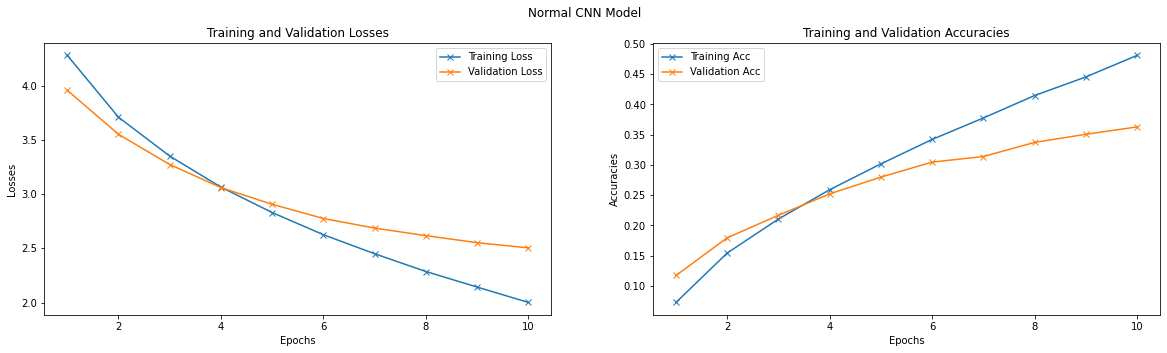

In [16]:
plot_history(normal_model_history, "Normal CNN Model")

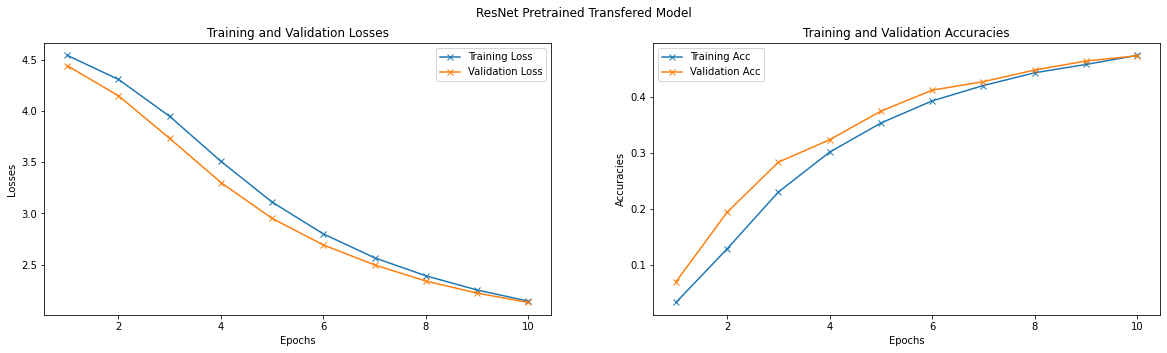

In [17]:
plot_history(transfer_model_history, "ResNet Pretrained Transfered Model")

In [18]:
model_test(model=best_normal_model, criterion=criterion, test_loader=normal_data_loader['test'])

Test time :  1.79s
Test Loss :  2.5027
Test Accuracy :  0.3611


In [19]:
model_test(model=best_transfer_model, criterion=criterion, test_loader=transfered_data_loader['test'])

Test time :  15.41s
Test Loss :  2.1266
Test Accuracy :  0.4734


In [20]:
_net = Net().to(device)
_normal_optimizer = optim.SGD(_net.parameters(), lr=normal_learning_rate, momentum=momentum)

print("New Conv Net :")
summary(model=_net, input_size=normal_input_shape, batch_size=batch_size, device=device)

New Conv Net :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [200, 16, 32, 32]             448
              ReLU-2          [200, 16, 32, 32]               0
       BatchNorm2d-3          [200, 16, 32, 32]              32
         MaxPool2d-4          [200, 16, 16, 16]               0
            Conv2d-5          [200, 32, 16, 16]           4,640
              ReLU-6          [200, 32, 16, 16]               0
       BatchNorm2d-7          [200, 32, 16, 16]              64
         MaxPool2d-8            [200, 32, 8, 8]               0
            Conv2d-9            [200, 64, 8, 8]          18,496
             ReLU-10            [200, 64, 8, 8]               0
      BatchNorm2d-11            [200, 64, 8, 8]             128
        MaxPool2d-12            [200, 64, 4, 4]               0
           Conv2d-13           [200, 128, 4, 4]          73,856
             ReLU-14    

In [21]:
_best_normal_model, _normal_model_history = model_train(
    model=_net, criterion=criterion,
    optimizer=_normal_optimizer, data_loader=normal_data_loader,
    epochs=100, epochs_to_watch=5, accuracy_min_diff = 0.001,
    max_val_acc_needed=max(transfer_model_history['validation']['accuracies'])
)

Epoch[001/100] :: Train (Loss =  4.3198, Acc =  0.0679), Validation (Loss =  4.0060, Acc =  0.1204), Epoch Time =  8.89s, Total Time =  8.89s
Epoch[002/100] :: Train (Loss =  3.7274, Acc =  0.1523), Validation (Loss =  3.5702, Acc =  0.1730), Epoch Time =  8.85s, Total Time =  17.74s
Epoch[003/100] :: Train (Loss =  3.3492, Acc =  0.2089), Validation (Loss =  3.3095, Acc =  0.2116), Epoch Time =  8.82s, Total Time =  26.57s
Epoch[004/100] :: Train (Loss =  3.0824, Acc =  0.2570), Validation (Loss =  3.1375, Acc =  0.2432), Epoch Time =  8.74s, Total Time =  35.31s
Epoch[005/100] :: Train (Loss =  2.8661, Acc =  0.2968), Validation (Loss =  2.9573, Acc =  0.2764), Epoch Time =  8.81s, Total Time =  44.12s
Epoch[006/100] :: Train (Loss =  2.6699, Acc =  0.3345), Validation (Loss =  2.8340, Acc =  0.2945), Epoch Time =  8.96s, Total Time =  53.08s
Epoch[007/100] :: Train (Loss =  2.4893, Acc =  0.3722), Validation (Loss =  2.7427, Acc =  0.3165), Epoch Time =  8.82s, Total Time =  61.90s


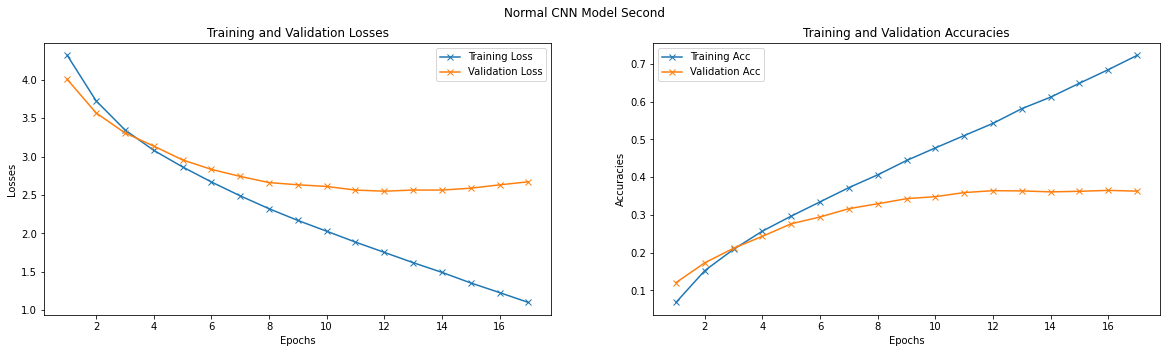

In [22]:
plot_history(_normal_model_history, "Normal CNN Model Second")

In [23]:
model_test(model=_best_normal_model, criterion=criterion, test_loader=normal_data_loader['test'])

Test time :  1.77s
Test Loss :  2.6038
Test Accuracy :  0.3712


In [24]:
torch.save(best_normal_model, 'normal_cnn.pth')
torch.save(best_transfer_model, 'resnet_transfered.pth')
torch.save(_best_normal_model, '_normal_cnn.pth')

In [25]:
files.download('normal_cnn.pth')
files.download('resnet_transfered.pth')
files.download('_normal_cnn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>